In [199]:
import pandas as pd

## Sqlite connection

In [200]:
import sqlite3
cnx = sqlite3.connect('db.sqlite3')
df = pd.read_sql_query("SELECT * FROM gui_forwards", cnx)

In [201]:
# df.head()

## Datetime column
change to datetime objects \
set as index

In [202]:
df['forward_date'] = pd.to_datetime(df['forward_date'])
df = df.set_index('forward_date')

In [203]:
# df.head()

## Print number with commas

In [204]:
value = 100000000
print(f'{value:,}')

100,000,000


## Grouby datetime (month, week, day, etc)

In [205]:
freq = 'D'
count = df.groupby(pd.Grouper(freq=freq)).count()['id']

In [206]:
count.head()

forward_date
2022-07-07     4
2022-07-08    14
2022-07-09    13
2022-07-10     8
2022-07-11     5
Freq: D, Name: id, dtype: int64

## Successful routes over time

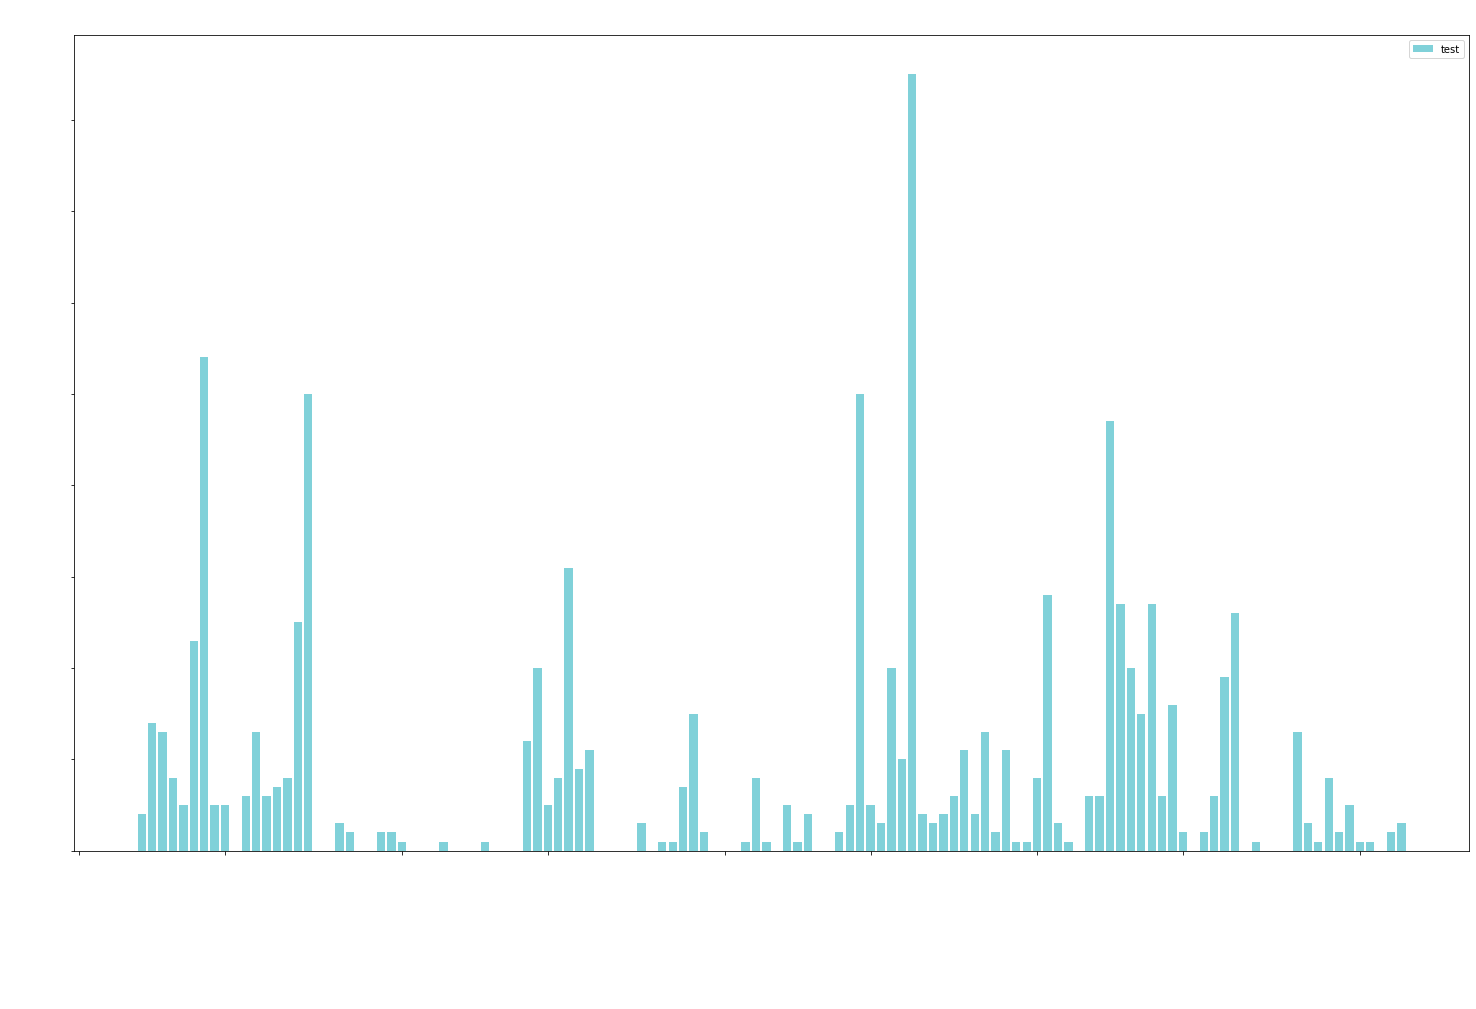

In [207]:
import matplotlib.pyplot as plt

labels = count.index
value = count

fig, ax = plt.subplots(figsize = (25, 15))

ax.bar(labels, value, label = 'test', color=['#80D1D9'])
plt.xticks(rotation=45)
plt.legend()
ax.set_title(f'BTC', fontsize=30, color='white')

plt.yticks(fontsize=30, color='white')
plt.xticks(fontsize=30, color='white')

plt.show()

## Failed HTLCs versus Successful Routes over time

In [208]:
htlc_df = pd.read_sql_query("SELECT * FROM gui_failedhtlcs", cnx)
fwds_df = pd.read_sql_query("SELECT * FROM gui_forwards", cnx)

htlc_df['timestamp'] = pd.to_datetime(htlc_df['timestamp'])
htlc_df = htlc_df.set_index('timestamp')
htlc_df['count'] = 1

fwds_df['forward_date'] = pd.to_datetime(fwds_df['forward_date'])
fwds_df = fwds_df.set_index('forward_date')
fwds_df['count'] = 1

In [209]:
frequency = 'D'
htlc_count = htlc_df.groupby(pd.Grouper(freq=frequency)).count()['id']
fwds_count = fwds_df.groupby(pd.Grouper(freq=frequency)).count()['id']

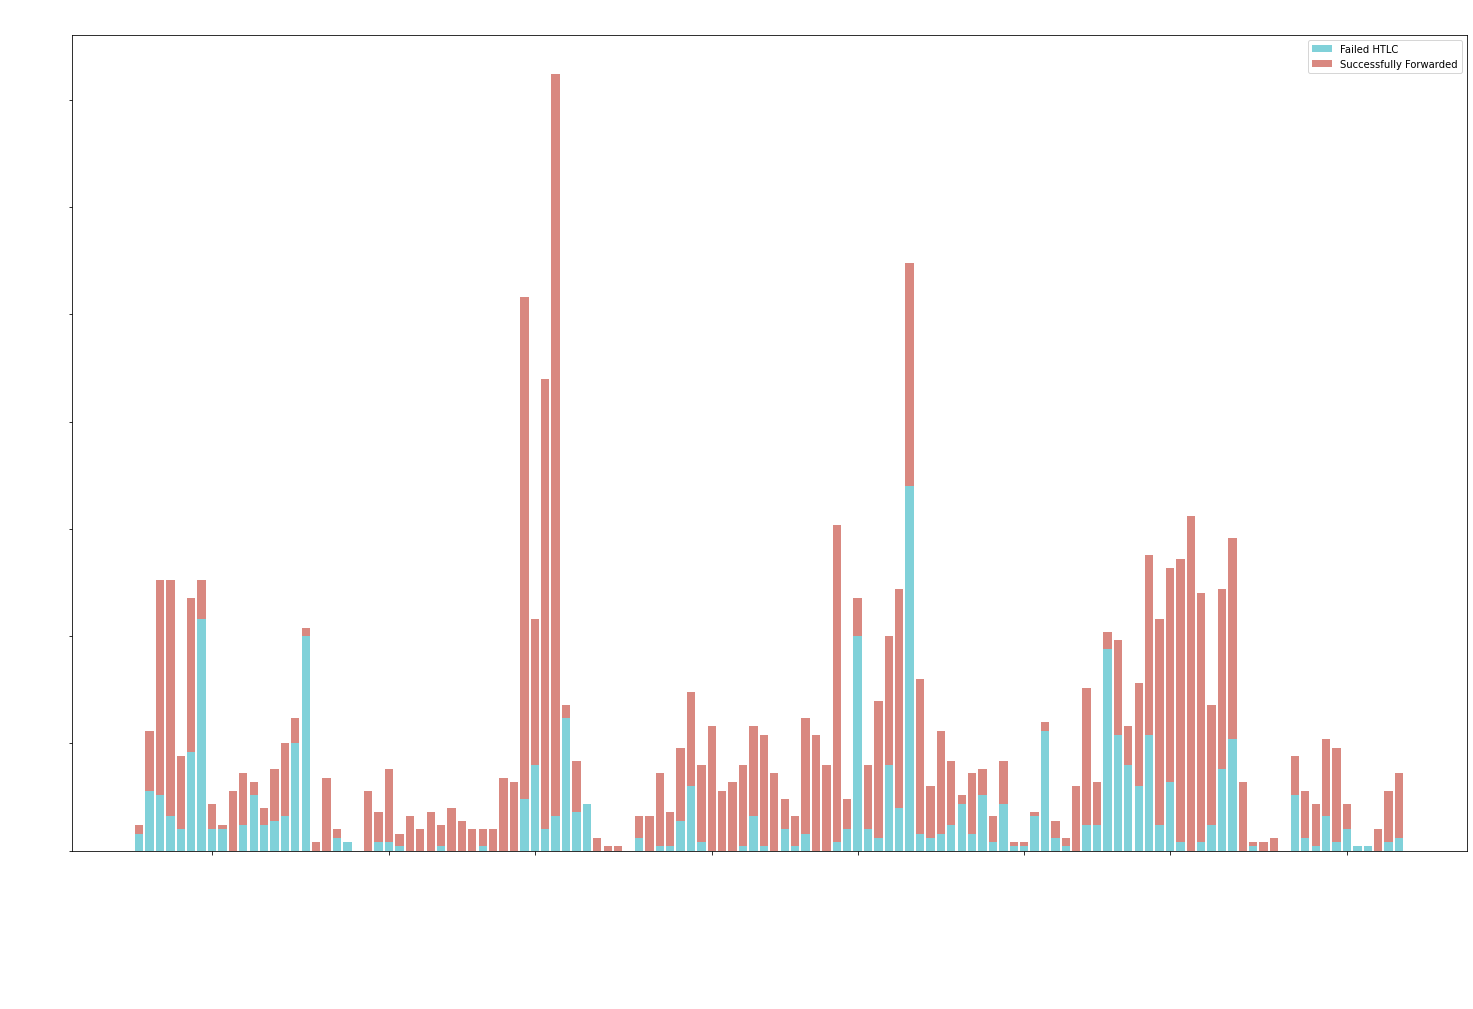

In [210]:
labels = htlc_count.index
htlc = htlc_count
fwds = fwds_count

fig, ax = plt.subplots(figsize = (25, 15))

ax.bar(labels, fwds, label = 'Failed HTLC', color=['#80D1D9'])
ax.bar(labels, htlc, bottom=fwds, label = 'Successfully Forwarded', color=['#D98880'])
plt.xticks(rotation=45)
plt.legend()
ax.set_title(f'BTC', fontsize=30, color='white')

plt.yticks(fontsize=30, color='white')
plt.xticks(fontsize=30, color='white')

plt.show()

## Value routed versus fees collected

In [211]:
freq = 'D'
value_total = df.groupby(pd.Grouper(freq=freq)).sum()['amt_out_msat']
fee_total = df.groupby(pd.Grouper(freq=freq)).sum()['fee']

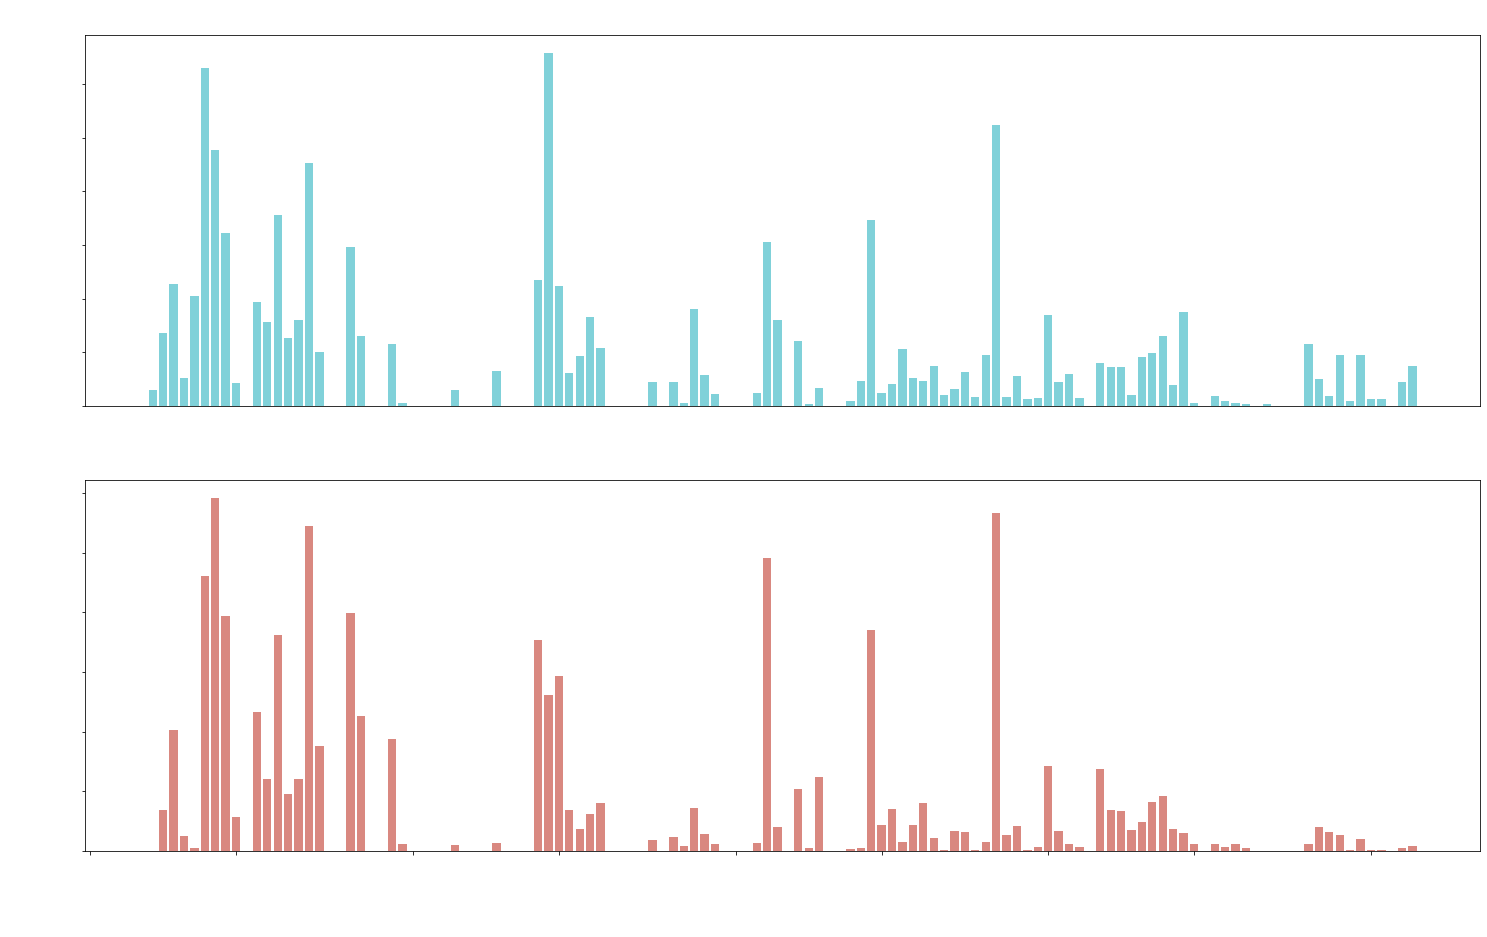

In [212]:
labels = value_total.index
value = value_total
fee = fee_total

fig, ax =  plt.subplots(2,1,figsize = (25, 15))

ax[0].bar(labels, value, label = 'Value Routed', color=['#80D1D9'])
ax[0].set_title(f'Value Routed', fontsize=30, color='white')
ax[0].tick_params(axis='both', which='both', labelsize=15, labelcolor='white')
ax[0].set_xticks([])
ax[0].set_ylabel('BTC', fontsize=30, color='white')

ax[1].bar(labels, fee, label = 'Fees Collected', color=['#D98880'])
ax[1].set_title(f'Fees Collected', fontsize=30, color='white')
ax[1].tick_params(axis='x', which='both', labelsize=15, labelcolor='white', labelrotation=45)
ax[1].tick_params(axis='both', which='both', labelsize=15, labelcolor='white')
ax[1].set_ylabel('sats', fontsize=30, color='white')

plt.show()

## Sparse matrix - Channels in vs Channels out

In [213]:
import scipy.sparse as sps

In [214]:
channels = list(set(list(df['chan_in_alias'].unique()) + list(df['chan_out_alias'].unique())))
channels_to_id = {p: i for i, p in enumerate(channels)}

In [215]:
sparse_df = fwds_df[['chan_in_alias', 'chan_out_alias']].reset_index(drop=True)

In [216]:
rows, cols, vals = [], [], []

for x in sparse_df.index:
    rows.append(channels_to_id[sparse_df.iloc[x][0]])
    cols.append(channels_to_id[sparse_df.iloc[x][1]])
    vals.append(1)

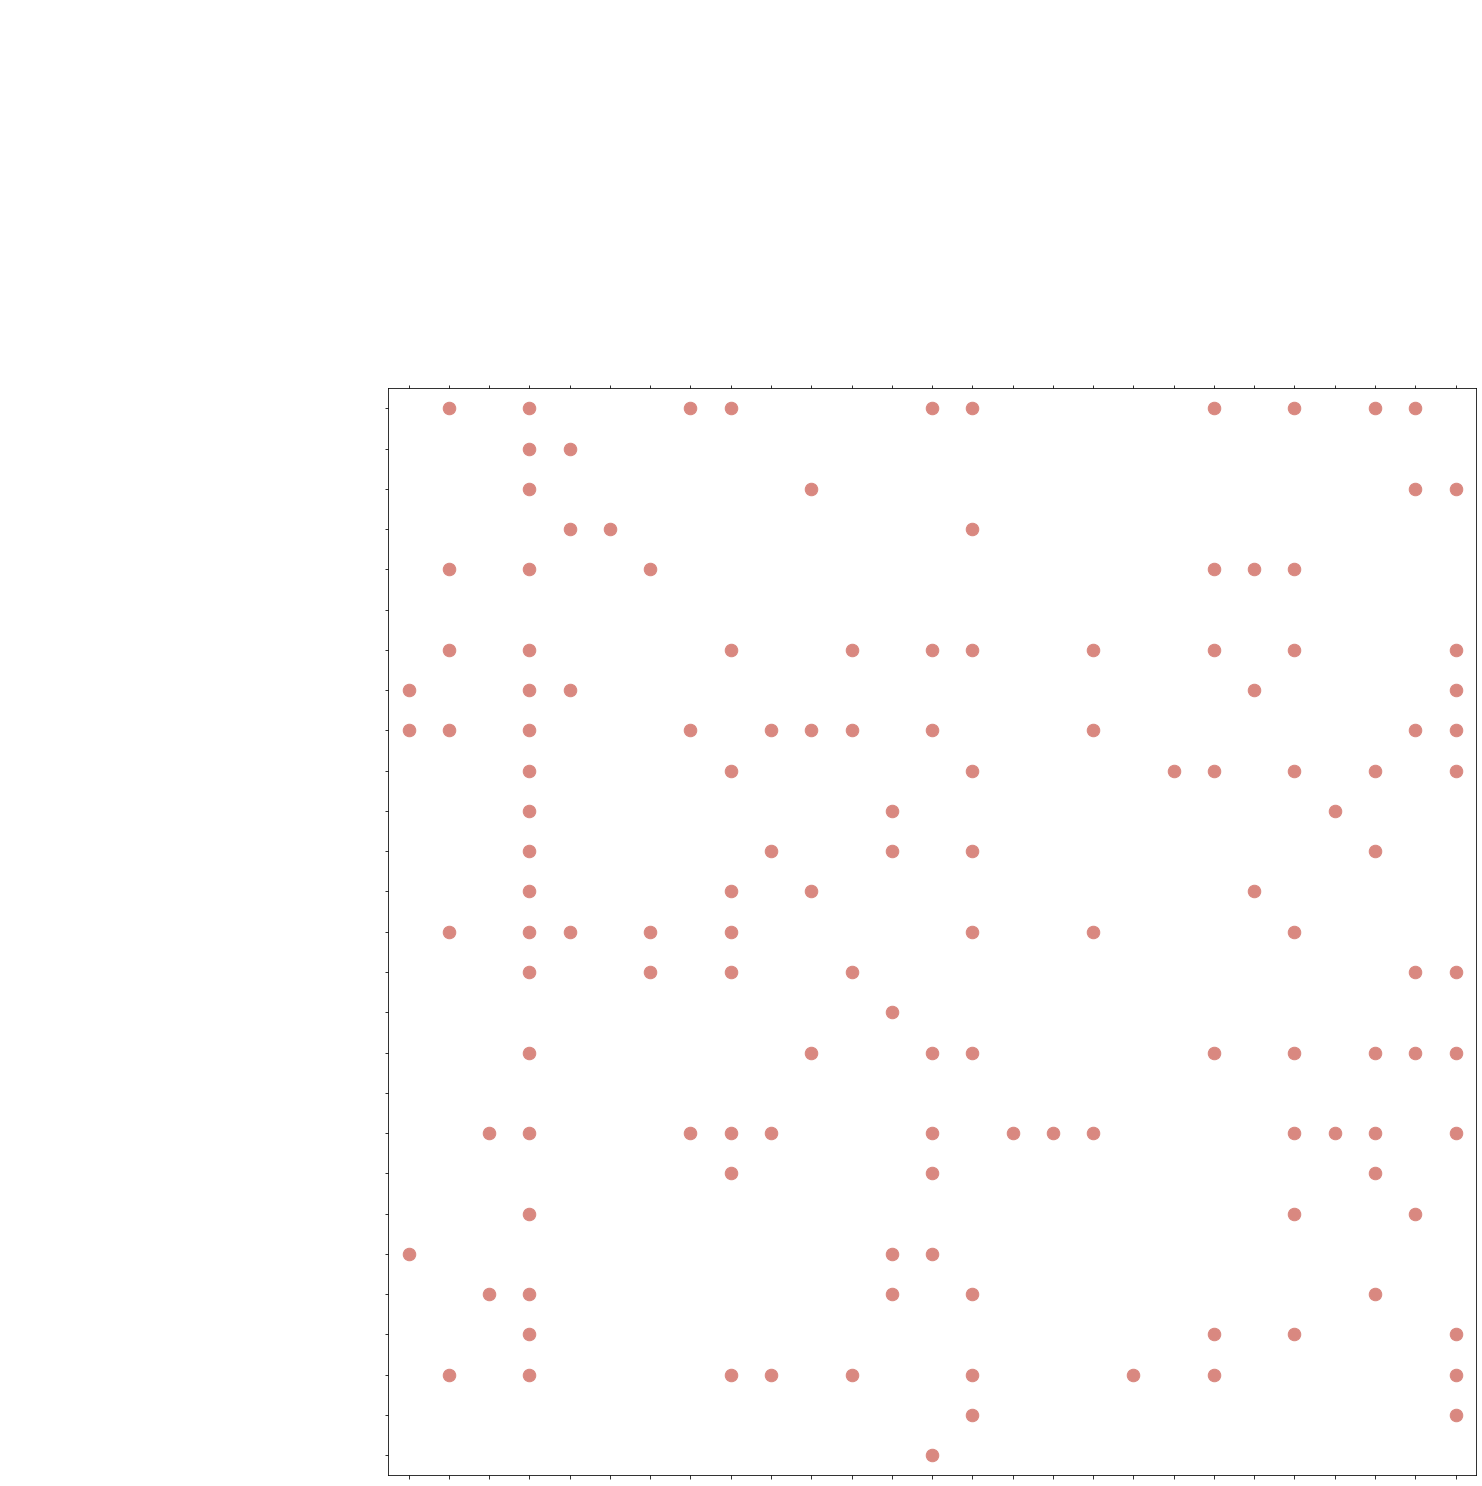

In [217]:
fig = plt.figure(figsize = (20,20))
M = sps.csr_matrix((vals, (rows, cols)), shape=(len(channels), len(channels)))
plt.spy(M, marker='.', markersize=25, color='#D98880')
plt.xticks(np.arange(0, len(channels), 1), channels, rotation=90, fontsize=25, color='white')
plt.yticks(np.arange(0, len(channels), 1), channels, fontsize=25, color='white')

fig.savefig('data0.pdf', bbox_inches='tight')